# Pré processamento

In [215]:
# Importando as bibliotecas e construindo o dataframe
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import faiss
import random
from sklearn.impute import KNNImputer
from sentence_transformers import SentenceTransformer
import mlflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import seaborn as sns

In [216]:
# concatenando dois dataframes (um com fake news e outro com noticias verdadeiras)
fake_df = pd.read_csv('https://raw.githubusercontent.com/guilopesrbc/fake_news_detector/main/Fake.csv')
true_df = pd.read_csv('https://raw.githubusercontent.com/guilopesrbc/fake_news_detector/main/True.csv')
# adicionando coluna label, correspondente a veracidade da noticias (1 para verdadeiro e 0 para falsa)
fake_df['label'] = 0
true_df['label'] = 1

combined_df = pd.concat([fake_df, true_df], ignore_index=True)

combined_df.to_csv('Combined.csv', index=False)
combined_df.reset_index(drop=True,inplace=True)
combined_df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


# Criando coluna num_of_words correspondente ao número de palavras presentes no texto da noticia

In [217]:
# criando coluna num_of_words correspondente ao número de palavras presentes no texto da noticia
import re
# regex para substituir caracteres que não forem letras e números
regex = r'[^a-zA-Z0-9\s]'
combined_df['text'] = combined_df['text'].map(lambda x: re.sub(regex, '', x))
combined_df['num_of_words'] = combined_df['text'].map(lambda x: len(x.split()))

# Criando nova coluna com texto vetorizado 

In [ ]:
# Initialize the Sentence Transformer model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Function to vectorize the text
def vectorize_text(text):
    return model.encode(text)

# Apply the function to create a new column with vectorized text
combined_df['text_vector'] = combined_df['text'].map(vectorize_text)
combined_df.to_csv('vectorized_texts.csv', index=False)

# Reading from csv file 

In [218]:
# Função para converter strings de vetores em numpy arrays de forma segura
def str_to_array(vector_str):
    try:
        # Remover caracteres desnecessários e converter a string para um numpy array
        cleaned_str = vector_str.replace('\n', '').replace('[', '').replace(']', '').replace('  ', ' ')
        return np.fromstring(cleaned_str, sep=' ')
    except Exception as e:
        print(f"Error converting string to array: {e}")
        return np.nan

def convert_text_vectors_from_str_to_np_arr():
    # Certifique-se de que os vetores de texto sejam numpy arrays, não strings
    df['text_vector'] = df['text_vector'].map(str_to_array) if isinstance(df['text_vector'][0], str) else df['text_vector']

    # Verifique se todos os vetores têm o mesmo tamanho
    vector_length = len(df['text_vector'][0])
    df['text_vector'] = df['text_vector'].map(lambda x: x if len(x) == vector_length else np.nan).dropna()

In [219]:
combined_df = pd.read_csv('vectorized.csv')
df = combined_df
convert_text_vectors_from_str_to_np_arr()
combined_df.head()

,title,text,subject,date,label,num_of_words,text_vector
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,492,"[-0.08635634, 0.16764247, 0.40040964, -0.36150..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,305,"[0.00671101, 0.0081033, -0.20852128, -0.087897..."
2,Sheriff David Clarke Becomes An Internet Joke...,On Friday it was revealed that former Milwauke...,News,"December 30, 2017",0,579,"[-0.362045884, -0.123025492, -0.551379442, -0...."
3,Trump Is So Obsessed He Even Has Obama’s Name...,On Christmas day Donald Trump announced that h...,News,"December 29, 2017",0,441,"[0.0173586905, 0.00204306096, 0.0736115128, 0...."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,420,"[-0.079019241, 0.473764718, 0.155274183, -0.05..."


# Setando campos como categóricos

In [220]:
combined_df.dtypes

title           object
text            object
subject         object
date            object
label            int64
num_of_words     int64
text_vector     object
dtype: object

In [221]:
# modificando a coluna subject
combined_df.loc[combined_df['subject'].isin(['politics', 'Government News', 'left-news']), 'subject'] = 'politics'
combined_df.loc[combined_df['subject'].isin(['US_News', 'News', 'Middle-east']), 'subject'] = 'worldnews'
combined_df.loc[combined_df['subject'] == 'politicsNews', 'subject'] = 'politics'
combined_df['subject'] = combined_df['subject'].astype('category')

In [222]:
combined_df.dtypes

title             object
text              object
subject         category
date              object
label              int64
num_of_words       int64
text_vector       object
dtype: object

In [223]:
combined_df['num_subjects'] = combined_df['subject'].cat.codes

In [224]:
combined_df.dtypes

title             object
text              object
subject         category
date              object
label              int64
num_of_words       int64
text_vector       object
num_subjects        int8
dtype: object

# Verificando valores nulos e vazios

In [225]:
# verificando valores nulo
combined_df.isnull().sum()

title           0
text            0
subject         0
date            0
label           0
num_of_words    0
text_vector     0
num_subjects    0
dtype: int64

In [226]:
# verificando valores vazios de titulo
remove_spaces = lambda x: ''.join(x.split()) if type(x) == str else x
empty_values = combined_df.applymap(remove_spaces)
empty_values['title'] = empty_values['title'] == ''
len(empty_values[empty_values['title'] == True])

0

In [227]:
# verificando valores vazios de texto
remove_spaces = lambda x: ''.join(x.split()) if type(x) == str else x
empty_values = combined_df.applymap(remove_spaces)
empty_values['text'] = empty_values['text'] == ''
len(empty_values[empty_values['text'] == True])

631

In [228]:
# verificando valores vazios de tipo de conteúdo
remove_spaces = lambda x: ''.join(x.split()) if type(x) == str else x
empty_values = combined_df.applymap(remove_spaces)
empty_values['subject'] = empty_values['subject'] == ''
len(empty_values[empty_values['subject'] == True])

0

In [229]:
# setando valores num_of_words iguais a 0 para nulo
df = combined_df
df['num_of_words'] = df['num_of_words'].map(lambda x: np.nan if x == 0 else x)
df['num_of_words'].isnull().sum()

631

# Dividindo o dataset em batches para otimizar o uso do algoritmo KNN  

In [230]:
batch_size = 5000
df_numpy = df.to_numpy()

# Embaralhar os dados,
np.random.shuffle(df_numpy)
# Dividir o dataset em batches,
n_batches = int(np.ceil(df_numpy.shape[0] / batch_size))  # Número de batches
batches = np.array_split(df_numpy, n_batches)
batches_df = [pd.DataFrame(batch, columns=df.columns) for batch in batches]
df = pd.DataFrame(df_numpy, columns=df.columns)

for batch in batches_df:
    print(batch.isnull().sum())

title            0
text             0
subject          0
date             0
label            0
num_of_words    77
text_vector      0
num_subjects     0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    71
text_vector      0
num_subjects     0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    64
text_vector      0
num_subjects     0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    63
text_vector      0
num_subjects     0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    77
text_vector      0
num_subjects     0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    72
text_vector      0
num_subjects     0
dtype: int64
title     

In [231]:
imputer = KNNImputer(n_neighbors=3)
df_num_of_words_knn = [pd.DataFrame(imputer.fit_transform(batch[['num_subjects', 'num_of_words', 'label']]), columns=df[['num_subjects', 'num_of_words', 'label']].columns) for batch in batches_df]


In [232]:
df_concatened = pd.DataFrame()
for batch in df_num_of_words_knn:
    df_concatened = pd.concat([df_concatened, batch], ignore_index=True)
    print(batch.isnull().sum())

num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64


In [233]:
df['num_of_words'] = df_concatened['num_of_words']
df.isnull().sum()

title           0
text            0
subject         0
date            0
label           0
num_of_words    0
text_vector     0
num_subjects    0
dtype: int64

# Normalização

In [234]:
df

,title,text,subject,date,label,num_of_words,text_vector,num_subjects
0,WATCH: Wolf Blitzer NAILS Giuliani To The Wal...,Sometimes it takes a wolf to catch a snakeRudy...,worldnews,"November 4, 2016",0,895.0,"[-0.24760108, -0.15191007, -0.2319191, 0.04011...",1
1,U.S. special envoy encouraged that Kurds could...,ERBIL Reuters Brett McGurk the US special env...,worldnews,"September 14, 2017",1,70.0,"[0.324408591, -0.032275863, -0.215139166, -0.2...",1
2,"U.S. oil industry cheers Trump energy pick, se...",WASHINGTON Reuters The US oil and gas industr...,politics,"December 14, 2016",1,842.0,"[-0.13728708, -0.358987063, 0.336106956, 0.276...",0
3,FAMILY OF S.C. SHOOTING VICTIM HAS A MESSAGE F...,Poor little Al if he s not race baiting he s h...,politics,"Apr 9, 2015",0,181.0,"[-0.14615326, 0.21741922, -0.3805332, -0.00558...",0
4,Henningsen on CrossTalk Debating ‘Trump & His ...,Has President Trump handed over US foreign pol...,worldnews,"September 15, 2017",0,99.0,"[-0.16768867, -0.18577558, -0.1245539, -0.2129...",1
...,...,...,...,...,...,...,...,...
44893,YIKES! HILLARY GOES OFF THE RAILS…Pulls A Howa...,,politics,"Nov 7, 2016",0,405.0,"[0.154727131, 0.180044174, 0.0589160696, -0.14...",0
44894,GENERAL BOYKIN On Gender Neutral Bathrooms: “…...,General Boykin spoke at The Awakening 2016 con...,politics,"Mar 10, 2016",0,21.0,"[0.199520901, 0.373766571, -0.172417685, 0.103...",0
44895,NuStar's St. Eustatius terminal damaged by Irm...,HOUSTON Reuters Nustar Energy s oil terminal ...,worldnews,"September 7, 2017",1,111.0,"[-0.225265995, -0.271191418, -0.114278704, -0....",1
44896,Iraq Redux: US-led Sanctions Against Syria Are...,Eva Bartlett RT OpEdgeThis month the Australia...,worldnews,"March 7, 2016",0,1854.0,"[-0.23379107, 0.16068941, -0.13154829, -0.1429...",1


In [235]:
# nomarlizando entre 0 e 1 min-max usando scikit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
df['subject_norm'] = scaler.fit_transform(df[['num_subjects']])
df['num_of_words_norm'] = scaler.fit_transform(df[['num_of_words']])
df.head()

,title,text,subject,date,label,num_of_words,text_vector,num_subjects,subject_norm,num_of_words_norm
0,WATCH: Wolf Blitzer NAILS Giuliani To The Wal...,Sometimes it takes a wolf to catch a snakeRudy...,worldnews,"November 4, 2016",0,895.0,"[-0.24760108, -0.15191007, -0.2319191, 0.04011...",1,1.0,0.110085
1,U.S. special envoy encouraged that Kurds could...,ERBIL Reuters Brett McGurk the US special env...,worldnews,"September 14, 2017",1,70.0,"[0.324408591, -0.032275863, -0.215139166, -0.2...",1,1.0,0.008496
2,"U.S. oil industry cheers Trump energy pick, se...",WASHINGTON Reuters The US oil and gas industr...,politics,"December 14, 2016",1,842.0,"[-0.13728708, -0.358987063, 0.336106956, 0.276...",0,0.0,0.103559
3,FAMILY OF S.C. SHOOTING VICTIM HAS A MESSAGE F...,Poor little Al if he s not race baiting he s h...,politics,"Apr 9, 2015",0,181.0,"[-0.14615326, 0.21741922, -0.3805332, -0.00558...",0,0.0,0.022165
4,Henningsen on CrossTalk Debating ‘Trump & His ...,Has President Trump handed over US foreign pol...,worldnews,"September 15, 2017",0,99.0,"[-0.16768867, -0.18577558, -0.1245539, -0.2129...",1,1.0,0.012067


In [236]:
df['subject_norm'].describe()

count    44898.000000
mean         0.462292
std          0.498582
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: subject_norm, dtype: float64

In [237]:
df['num_of_words_norm'].describe()

count    44898.000000
mean         0.050223
std          0.042815
min          0.000000
25%          0.025982
50%          0.044822
75%          0.063046
max          1.000000
Name: num_of_words_norm, dtype: float64

# Discretização

In [238]:
# discretizando com 10 bins com mesmo intervalo
df['num_of_words_dist'] = pd.cut(df['num_of_words'], 10)

In [239]:
df['num_of_words_dist'].value_counts()

num_of_words_dist
(-7.121, 813.1]     41552
(813.1, 1625.2]      2984
(1625.2, 2437.3]      201
(2437.3, 3249.4]       76
(3249.4, 4061.5]       44
(4061.5, 4873.6]       13
(4873.6, 5685.7]       12
(5685.7, 6497.8]        6
(6497.8, 7309.9]        6
(7309.9, 8122.0]        4
Name: count, dtype: int64

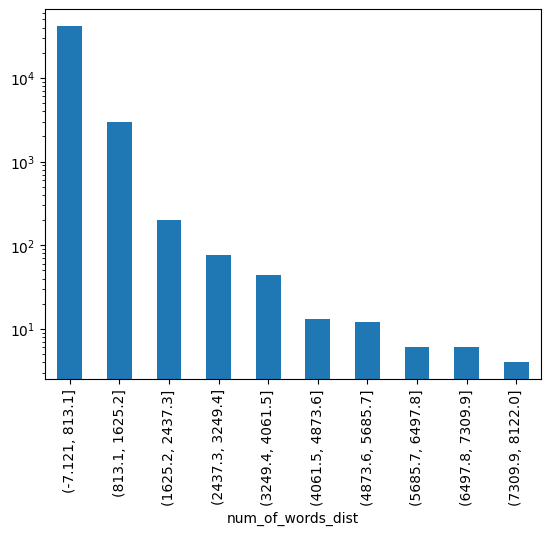

In [240]:
df['num_of_words_dist'].value_counts().plot(kind="bar")
plt.yscale("log")

# Detecção de outliers

In [241]:
df_without_text_vectors = df.drop(columns=['text_vector'])
duplicates = df[df_without_text_vectors.duplicated()]
duplicates.head()

,title,text,subject,date,label,num_of_words,text_vector,num_subjects,subject_norm,num_of_words_norm,num_of_words_dist
708,Should We Worry About McMaster as Trump’s Nati...,21st Century Wire says Is McMaster going to re...,worldnews,"March 2, 2017",0,121.0,"[-0.24047403, -0.0386509225, -0.214063764, -0....",1,1.0,0.014777,"(-7.121, 813.1]"
1089,HEAD OF NATION’S TOP IMMIGRATION LAW ENFORCEME...,Obama s ICE Director Sarah Saldana is not the ...,politics,"Jul 21, 2015",0,1171.0,"[-0.288147449, 0.0999377072, -0.359854341, 0.0...",0,0.0,0.144071,"(813.1, 1625.2]"
1245,(VIDEO) KRAUTHAMMER: FORMER CIA DEPUTY DIRECTO...,,politics,"May 12, 2015",0,274.0,"[0.154727131, 0.180044174, 0.0589160696, -0.14...",0,0.0,0.033617,"(-7.121, 813.1]"
1279,BREITBART’S JOEL POLLACK Brilliantly Shuts Dow...,Watch Joy Behar as she hilariously attempts to...,politics,"Feb 26, 2017",0,140.0,"[-0.05973461, 0.34923112, -0.19347763, 0.02663...",0,0.0,0.017116,"(-7.121, 813.1]"
1384,NOT KIDDING: Call A Transexual “He” If He Want...,The LGBT mafia has never been more threatening...,politics,"Dec 28, 2015",0,474.0,"[-0.000428308733, 0.264524966, -0.213730097, -...",0,0.0,0.058244,"(-7.121, 813.1]"


In [242]:
duplicates_mask = df_without_text_vectors.duplicated(keep=False)

# Drop duplicates from the original DataFrame
df = df[~duplicates_mask]

In [243]:
duplicates = df[df_without_text_vectors.duplicated()]
duplicates.head()

/tmp/ipykernel_106480/4099902805.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  duplicates = df[df_without_text_vectors.duplicated()]


,title,text,subject,date,label,num_of_words,text_vector,num_subjects,subject_norm,num_of_words_norm,num_of_words_dist


<AxesSubplot: >

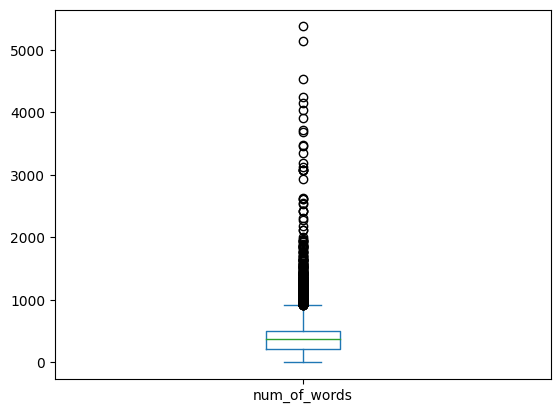

In [244]:
df['num_of_words'].plot.box()

<AxesSubplot: ylabel='Frequency'>

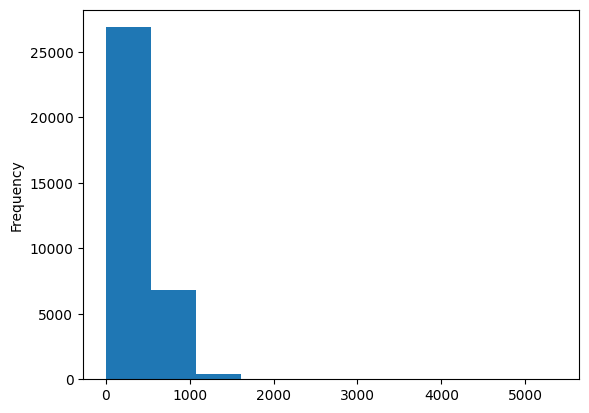

In [245]:
df['num_of_words'].plot.hist()

/tmp/ipykernel_106480/1135887764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_num_of_words'] = np.log10(df['num_of_words'])


<AxesSubplot: ylabel='Frequency'>

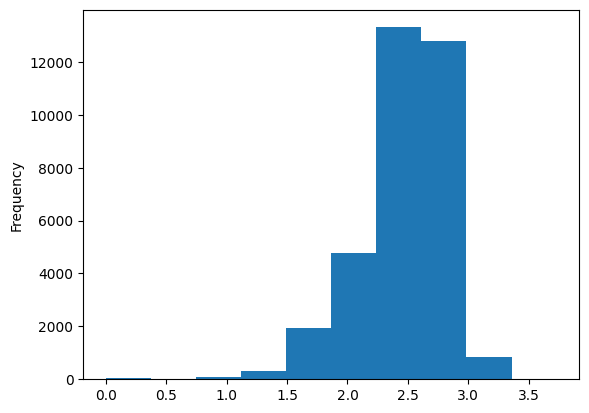

In [246]:
df['log_num_of_words'] = np.log10(df['num_of_words'])
df['log_num_of_words'].plot.hist()

In [247]:
mad = np.abs(df['log_num_of_words'] - df['log_num_of_words'].median()).median()*(1/0.6745)
print(mad)

0.23995673823731847


<AxesSubplot: >

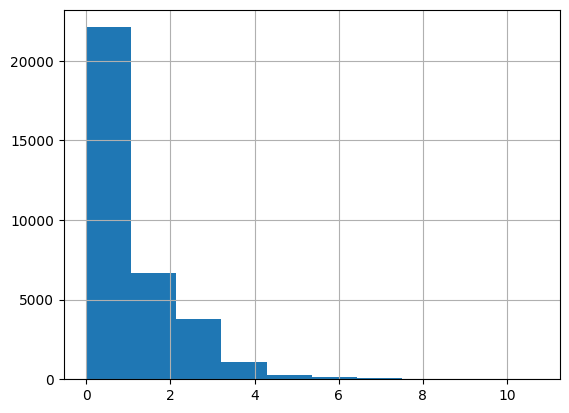

In [248]:
(np.abs(df['log_num_of_words']-df['log_num_of_words'].median())/mad).hist()

In [249]:
df[np.abs(df['log_num_of_words']-df['log_num_of_words'].median())/mad > 3.5]

,title,text,subject,date,label,num_of_words,text_vector,num_subjects,subject_norm,num_of_words_norm,num_of_words_dist,log_num_of_words
22,A FAREWELL TO NANCY: A One-Of-A-Kind Love Stor...,The greatest love affair in the history of th...,politics,"Mar 7, 2016",0,22.0,"[0.16618885, 0.08449571, -0.24175355, -0.23631...",0,0.0,0.002586,"(-7.121, 813.1]",1.342423
31,"BOOM! DONALD TRUMP, JR Wins Best Cruz Comment ...",The best unity I saw was everyone booing him ...,politics,"Jul 21, 2016",0,40.0,"[0.227968886, 0.222876042, -0.0487879254, -0.2...",0,0.0,0.004802,"(-7.121, 813.1]",1.602060
106,LANGUAGE WARNING BUT SO FUNNY! LISTEN TO TWO B...,This is a little racy but pretty funny,politics,"Jul 28, 2015",0,8.0,"[-0.13664642, 0.341801077, 0.131704107, -0.087...",0,0.0,0.000862,"(-7.121, 813.1]",0.903090
119,Turkey detains seven people over explosion at ...,ANKARA Reuters Turkish authorities have detai...,worldnews,"October 12, 2017",1,53.0,"[0.34875536, 0.00436777063, -0.241525367, -0.1...",1,1.0,0.006403,"(-7.121, 813.1]",1.724276
176,WOW! IVANKA TRUMP Was The Best Speech Yet At T...,The expectations were high for Ivanka Trump s ...,politics,"Jul 21, 2016",0,28.0,"[0.22609894, 0.19621006, 0.1341668, 0.26697606...",0,0.0,0.003325,"(-7.121, 813.1]",1.447158
...,...,...,...,...,...,...,...,...,...,...,...,...
44625,"KELLYANNE CONWAY: “I’m not a sore winner, I’m ...",AWESOME KellyannePolls I m Not A Sore WinnerI...,politics,"Dec 12, 2016",0,27.0,"[-0.0768788755, -0.140242144, 0.123816587, -0....",0,0.0,0.003202,"(-7.121, 813.1]",1.431364
44690,OBAMA HOSTS MUSLIM EID CELEBRATION…Jabs Trump ...,OBAMA LIES AND SPINS HIS WAY THROUGH A BS SPEE...,politics,"Jul 22, 2016",0,11.0,"[0.130046278, 0.000874938734, 0.00485799788, -...",0,0.0,0.001231,"(-7.121, 813.1]",1.041393
44791,DUCK DYNASTY’S PHIL ROBERTSON Weighs In On Tru...,Phil Robertson of Duck Dynasty has endorsed Do...,politics,"May 24, 2016",0,19.0,"[0.0884414762, 0.0510905907, 0.229506999, -0.0...",0,0.0,0.002216,"(-7.121, 813.1]",1.278754
44823,Tillerson calls Mexico long-standing friend of...,WASHINGTON Reuters US Secretary of State nomi...,politics,"January 11, 2017",1,53.0,"[0.0491739139, -0.210572869, 0.1955484, -0.013...",0,0.0,0.006403,"(-7.121, 813.1]",1.724276


In [250]:
len(df)

34134

In [251]:
df = df[abs(df['log_num_of_words']-df['log_num_of_words'].median())/mad < 3.5]

In [252]:
len(df)

33060

# Gerando análises de similaridade

In [253]:
from scipy.stats import ttest_ind

# Convert the list of vectors to a numpy array
vectors = np.vstack(df['text_vector'].to_numpy())

# Build the FAISS index
dimension = vectors.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(vectors)

In [254]:
# Selecionando 1000 notícias falsas e 1000 verdadeiras para cada assunto
fake_data = df[df['label'] == 0].groupby('subject').sample(1000)
true_data = df[df['label'] == 1].groupby('subject').sample(1000)

# Concatenando os dados selecionados
selected_data = pd.concat([fake_data, true_data])

# Listas para armazenar as similaridades
fake_vs_fake_similarities = []
true_vs_true_similarities = []
true_vs_fake_similarities = []

for subject in ['politics', 'worldnews']:
    fake_indices = fake_data[fake_data['subject'] == subject].index
    true_indices = true_data[true_data['subject'] == subject].index
    
    for fake_index in fake_indices:
        query_vector = selected_data[selected_data.index == fake_index]['text_vector'].iloc[0]
        distances, indices = index.search(np.array([query_vector]), len(selected_data))
        
        # Encontrar similaridades falsas vs falsas
        fake_vs_fake_similarities.extend([distances[0][i] for i in range(len(indices[0])) if indices[0][i] in fake_indices])
        
        # Encontrar similaridades falsas vs verdadeiras
        true_indices_in_results = [i for i in indices[0] if i in true_indices]
        if true_indices_in_results:
            true_vs_fake_similarities.append(distances[0][indices[0].tolist().index(true_indices_in_results[0])])
    
    for true_index in true_indices:
        query_vector = selected_data[selected_data.index == true_index]['text_vector'].iloc[0]
        distances, indices = index.search(np.array([query_vector]), len(selected_data))
        
        # Encontrar similaridades verdadeiras vs verdadeiras
        true_vs_true_similarities.extend([distances[0][i] for i in range(len(indices[0])) if indices[0][i] in true_indices])
        
        # Encontrar similaridades verdadeiras vs falsas
        fake_indices_in_results = [i for i in indices[0] if i in fake_indices]
        if fake_indices_in_results:
            true_vs_fake_similarities.append(distances[0][indices[0].tolist().index(fake_indices_in_results[0])])

# Estatísticas descritivas

## Histograma de distribuição do número de palavras

O histograma ilustra a distribuição do número de palavras após uma transformação logarítmica. A maioria dos textos concentra-se em torno de cerca de 6 palavras, com uma diminuição gradual na frequência à medida que o número de palavras aumenta. Textos muito curtos (menos de 4 palavras) ou muito longos (mais de 7 palavras) são menos comuns. Em suma, a análise revela que a maioria dos textos possui um número moderado de palavras, com uma concentração significativa em torno de 6 palavras, destacando a predominância de textos de comprimento médio.

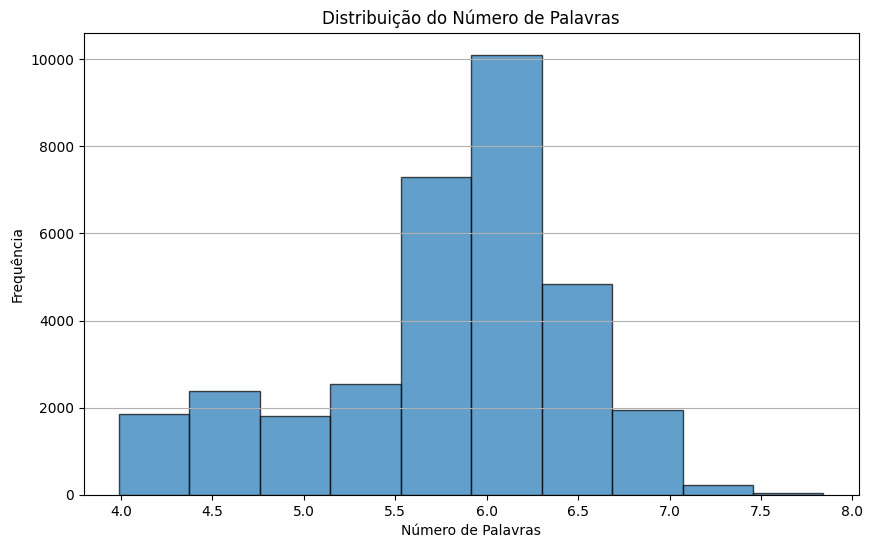

In [255]:
plt.figure(figsize=(10, 6))
plt.hist(np.log(df['num_of_words']), bins=10, edgecolor='black', alpha=0.7)
plt.title('Distribuição do Número de Palavras')
plt.xlabel('Número de Palavras')
plt.ylabel('Frequência')
plt.grid(axis='y')
plt.show()

## Boxplot representando o número de palavras

O boxplot mostra a distribuição do número de palavras em textos após uma transformação logarítmica. A mediana é cerca de 6, sugerindo que a maioria dos textos tem em torno de 6 palavras. A caixa do boxplot, entre o primeiro e terceiro quartil, indica que 50% dos textos possuem entre aproximadamente 5 e 6,5 palavras. Os "whiskers" indicam a variação esperada dos dados até 1,5 vezes o intervalo interquartil (IQR). Além disso, há outliers representando textos muito curtos (menos de 4 palavras) ou muito longos (mais de 7 palavras). Em síntese, a análise revela que a maioria dos textos tem um número moderado de palavras, com a predominância de textos de comprimento médio, sendo textos extremamente curtos ou longos menos frequentes.

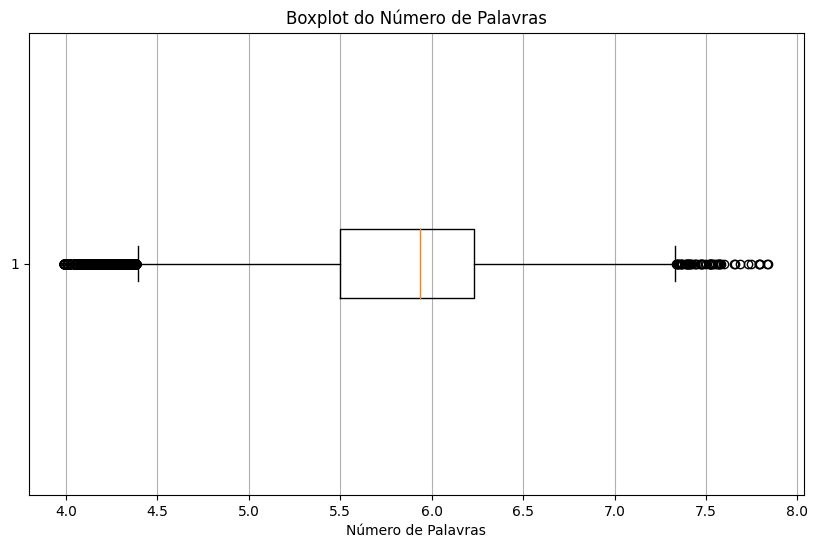

In [256]:
# Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(np.log(df['num_of_words']), vert=False)
plt.title('Boxplot do Número de Palavras')
plt.xlabel('Número de Palavras')
plt.grid(axis='x')
plt.show()

## Gráfico de barras comparando o número de notícias falsas vs verdadeiras por ano

O gráfico abaixo compara o número de notícias falsas e verdadeiras publicadas anualmente de 2015 a 2018. 
As conclusões são:

2015: Poucas notícias, com ligeira predominância das falsas.
2016: Aumento significativo de notícias, com mais falsas do que verdadeiras.
2017: Pico de notícias, com um aumento expressivo em ambas as categorias, sendo as verdadeiras consideravelmente mais numerosas.
2018: Poucas notícias, tanto falsas quanto verdadeiras, indicando baixa coleta de dados ou atividade mínima.

Em resumo, o período de 2016 a 2017 registrou um aumento acentuado na produção ou coleta de notícias, com destaque para 2017, especialmente para as notícias verdadeiras.

In [257]:
date_formats = ['%B%d,%Y', '%d-%b-%y', '%B%d,%Y', '%b%d,%Y', '%d-%b-%Y', '%d%B%Y', '%d%b%Y', '%Y-%m-%d', '%m-%d-%Y', '%Y/%m/%d', '%B%d,%Y', '%B%d,%Y', '%B%d,%Y', '%B%d,%Y']

def is_valid_date(date_str):
    for format_str in date_formats:
        try:
            return pd.to_datetime(re.sub(r'\s+', '', str(date_str)), format=format_str)
        except ValueError:
            pass

    return pd.NaT

valid_dates = df.copy()
valid_dates['date'] = valid_dates['date'].map(is_valid_date)
valid_dates['year'] = valid_dates['date'].dt.year

<Figure size 1200x600 with 0 Axes>

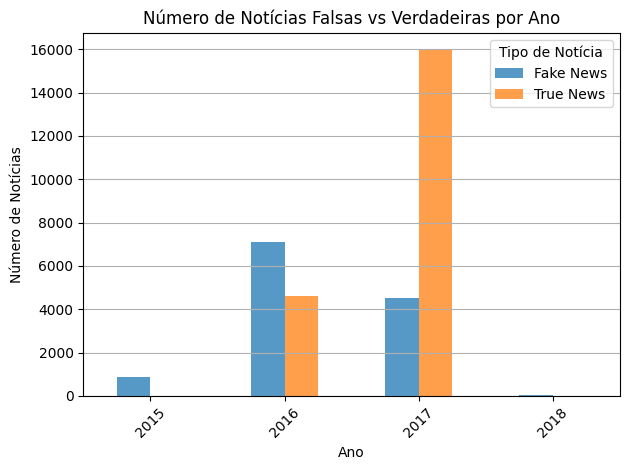

In [258]:
# Contar o número de notícias falsas e verdadeiras por ano
fake_news_per_year = valid_dates[valid_dates['label'] == 0].groupby('year').size()
true_news_per_year = valid_dates[valid_dates['label'] == 1].groupby('year').size()

# Criar um DataFrame com esses dados
news_counts_per_year = pd.DataFrame({
    'Fake News': fake_news_per_year,
    'True News': true_news_per_year
}).fillna(0)  # Preencher valores ausentes com 0

# Plotar o gráfico
plt.figure(figsize=(12, 6))
news_counts_per_year.plot(kind='bar', stacked=False, alpha=0.75)
plt.title('Número de Notícias Falsas vs Verdadeiras por Ano')
plt.xlabel('Ano')
plt.ylabel('Número de Notícias')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Notícia')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

## Gráfico de Similaridade em Notícias Verdadeiras, Falsas e Mistas

### Descrição dos Gráficos de Similaridade em Notícias Verdadeiras, Falsas e Mistas

O gráfico compara a similaridade das notícias falsas, verdadeiras e mistas em relação aos subjects "worldnews" e "politics". A similaridade é representada pela distância média (quanto menor a distância, maior a similaridade).

### Análise

- Fake vs Fake: Notícias falsas têm uma similaridade moderada, com uma distância média em torno de 20.
- True vs True: Notícias verdadeiras têm a menor similaridade, com a maior distância média, ligeiramente acima de 20.
- True vs Fake: Notícias mistas têm a maior similaridade, com a menor distância média, aproximadamente 15.

### Conclusão

As notícias mistas (verdadeiras vs falsas) mostram maior similaridade entre si, indicando que as notícias verdadeiras e falsas compartilham características comuns. As notícias verdadeiras mantêm menor similaridade quando comparadas entre si, enquanto as notícias falsas também têm uma similaridade moderada dentro do seu grupo.

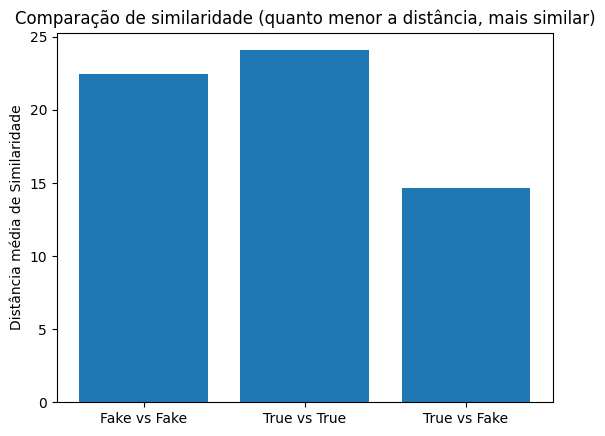

In [259]:
# Calculando as médias das similaridades
labels = ['Fake vs Fake', 'True vs True', 'True vs Fake']
similarities = [np.mean(fake_vs_fake_similarities), np.mean(true_vs_true_similarities), np.mean(true_vs_fake_similarities)]

# Plotando as similaridades
plt.bar(labels, similarities)
plt.ylabel('Distância média de Similaridade')
plt.title('Comparação de similaridade (quanto menor a distância, mais similar)')
plt.show()

# Teste de hipótese

## Teste de Hipótese: Similaridade entre Notícias Verdadeiras, Falsas e Mistas

Neste notebook, realizaremos um teste de hipótese para comparar a similaridade entre notícias verdadeiras, falsas e mistas. A similaridade é medida pela distância média (quanto menor a distância, maior a similaridade). O objetivo é determinar se há uma diferença significativa na similaridade entre as diferentes categorias de notícias.

### Passos do Teste de Hipótese

#### Definir Hipóteses:

- \(H_0\) (Hipótese Nula): Não há diferença significativa na similaridade entre as diferentes categorias de notícias.
- \(H_a\) (Hipótese Alternativa): Há uma diferença significativa na similaridade entre as diferentes categorias de notícias.

#### Calcular as Distâncias Médias:

- Obter as distâncias médias para cada categoria: Fake vs Fake, True vs True, e True vs Fake.

#### Realizar Teste de Hipótese:

- Usar o teste t de Student para comparar as distâncias médias entre as categorias.

#### Analisar os Resultados:

- Interpretar os valores p para determinar se rejeitamos ou não a hipótese nula.

## Resultados dos Testes de Hipótese

Os resultados dos testes para comparar as similaridades entre as diferentes categorias de notícias são os seguintes:

### Teste entre Fake vs Fake e True vs True:

- T-statistic: -16.37274849962382
- P-value: 1.6354346712162612e-56
- Conclusão: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre Fake vs Fake e True vs True.
- Observação: O resultado é altamente significativo (p < 0.01).

### Teste entre Fake vs Fake e True vs Fake:

- T-statistic: 25.650055569958536
- P-value: 1.199788220568109e-125
- Conclusão: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre Fake vs Fake e True vs Fake.
- Observação: O resultado é altamente significativo (p < 0.01).

### Teste entre True vs True e True vs Fake:

- T-statistic: 44.84103110401803
- P-value: 2.239345677091325e-302
- Conclusão: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre True vs True e True vs Fake.
- Observação: O resultado é altamente significativo (p < 0.01).


In [260]:
def perform_t_test(sample1, sample2, label1, label2):
    t_stat, p_value = ttest_ind(sample1, sample2, equal_var=False)
    print(f"Teste t de Student entre {label1} e {label2}:")
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}\n")
    
    # Interpretação dos resultados
    alpha = 0.05  # Nível de significância de 5%
    if p_value < alpha:
        print(f"Resultado: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre {label1} e {label2}.")
    else:
        print(f"Resultado: Não rejeitamos a hipótese nula. Não há diferença significativa na similaridade entre {label1} e {label2}.")

    # Detalhes adicionais para interpretação
    if p_value < 0.01:
        print("Observação: O resultado é altamente significativo (p < 0.01).")
    elif p_value < 0.05:
        print("Observação: O resultado é estatisticamente significativo (p < 0.05).")
    else:
        print("Observação: O resultado não é estatisticamente significativo (p >= 0.05).")

    print("\n" + "-"*50 + "\n")

# Realizando os testes de hipótese
cropped_sample_fake_vs_fake = random.sample(fake_vs_fake_similarities, 1000)
cropped_sample_true_vs_true = random.sample(true_vs_true_similarities, 1000)
cropped_sample_true_vs_fake = random.sample(true_vs_fake_similarities, 1000)

perform_t_test(cropped_sample_fake_vs_fake, cropped_sample_true_vs_true, 'Fake vs Fake', 'True vs True')
perform_t_test(cropped_sample_fake_vs_fake, cropped_sample_true_vs_fake, 'Fake vs Fake', 'True vs Fake')
perform_t_test(cropped_sample_true_vs_true, cropped_sample_true_vs_fake, 'True vs True', 'True vs Fake')

Teste t de Student entre Fake vs Fake e True vs True:
T-statistic: -5.679176808804992
P-value: 1.6106258698242824e-08

Resultado: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre Fake vs Fake e True vs True.
Observação: O resultado é altamente significativo (p < 0.01).

--------------------------------------------------

Teste t de Student entre Fake vs Fake e True vs Fake:
T-statistic: 27.589761355917773
P-value: 2.2408647843001214e-139

Resultado: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre Fake vs Fake e True vs Fake.
Observação: O resultado é altamente significativo (p < 0.01).

--------------------------------------------------

Teste t de Student entre True vs True e True vs Fake:
T-statistic: 45.551375161752695
P-value: 1.9669389669823703e-308

Resultado: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre True vs True e True vs Fake.
Observação: O resultado é altamente significativ

## Teste Qui-Quadrado para Proporção de Notícias Falsas em Textos Curtos e Longos

O código abaixo realiza um teste qui-quadrado de contingência para avaliar a proporção de notícias falsas em textos curtos (com menos de 150 palavras) e longos (com 150 palavras ou mais). Após dividir as notícias em categorias com base no comprimento, são calculadas as proporções de notícias falsas e verdadeiras em cada categoria. O teste estatístico é realizado e o resultado é exibido, mostrando a estatística Qui-Quadrado (Chi2) e o valor P associado. No caso específico deste teste, em que o resultado foi: Chi2 statistic: 188.04, P-value: 0.00000, conclui-se que há uma diferença estatisticamente significativa na proporção de notícias falsas entre textos curtos e longos. Isso sugere que a probabilidade de uma notícia ser falsa está associada ao comprimento do texto. As proporções de notícias falsas e verdadeiras são exibidas para ambas as categorias, e é destacado que é mais provável que um texto longo seja uma notícia falsa em comparação a um texto curto, enquanto é mais provável que um texto curto seja uma notícia verdadeira em comparação a um texto longo.

In [261]:
from scipy.stats import chi2_contingency

# Dividir as notícias em curtas e longas
short_texts = selected_data[selected_data['num_of_words'] < 150]
long_texts = selected_data[selected_data['num_of_words'] >= 150]

# Calcular a proporção de notícias falsas e verdadeiras em cada categoria
short_fake_count = short_texts[short_texts['label'] == 0].shape[0]
short_true_count = short_texts[short_texts['label'] == 1].shape[0]
long_fake_count = long_texts[long_texts['label'] == 0].shape[0]
long_true_count = long_texts[long_texts['label'] == 1].shape[0]

short_fake_proportion = short_fake_count / short_texts.shape[0]
short_true_proportion = short_true_count / short_texts.shape[0]
long_fake_proportion = long_fake_count / long_texts.shape[0]
long_true_proportion = long_true_count / long_texts.shape[0]

# Preparar os dados para o teste qui-quadrado de contingência
contingency_table = pd.DataFrame({
    'Short Texts': [short_fake_count, short_true_count],
    'Long Texts': [long_fake_count, long_true_count]
}, index=['Fake', 'True'])

# Realizar o teste qui-quadrado de contingência
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2 statistic: {chi2:.2f}, P-value: {p:.5f}")

if p < 0.05:
    print("Há uma diferença estatisticamente significativa na proporção de notícias falsas entre textos curtos e longos. "
          "Isso sugere que a probabilidade de uma notícia ser falsa está associada ao comprimento do texto.")

    print(f"Proporção de notícias falsas entre textos curtos: {short_fake_proportion:.2%}")
    print(f"Proporção de notícias verdadeiras entre textos curtos: {short_true_proportion:.2%}")
    print(f"Proporção de notícias falsas entre textos longos: {long_fake_proportion:.2%}")
    print(f"Proporção de notícias verdadeiras entre textos longos: {long_true_proportion:.2%}")

    if short_fake_proportion > long_fake_proportion:
        print("É mais provável que um texto curto seja uma notícia falsa comparado a um texto longo.")
    else:
        print("É mais provável que um texto longo seja uma notícia falsa comparado a um texto curto.")

    if short_true_proportion > long_true_proportion:
        print("É mais provável que um texto curto seja uma notícia verdadeira comparado a um texto longo.")
    else:
        print("É mais provável que um texto longo seja uma notícia verdadeira comparado a um texto curto.")
else:
    print("Não há uma diferença estatisticamente significativa na proporção de notícias falsas entre textos curtos e longos. "
          "Isso sugere que a probabilidade de uma notícia ser falsa não está associada ao comprimento do texto.")

Chi2 statistic: 188.04, P-value: 0.00000
Há uma diferença estatisticamente significativa na proporção de notícias falsas entre textos curtos e longos. Isso sugere que a probabilidade de uma notícia ser falsa está associada ao comprimento do texto.
Proporção de notícias falsas entre textos curtos: 24.39%
Proporção de notícias verdadeiras entre textos curtos: 75.61%
Proporção de notícias falsas entre textos longos: 54.62%
Proporção de notícias verdadeiras entre textos longos: 45.38%
É mais provável que um texto longo seja uma notícia falsa comparado a um texto curto.
É mais provável que um texto curto seja uma notícia verdadeira comparado a um texto longo.


# Classificação - Projeto 2

In [262]:
# setando label para int, para utilizar o modelo
df['label'] = df['label'].astype('int')
df.dtypes

title                  object
text                   object
subject                object
date                   object
label                   int64
num_of_words          float64
text_vector            object
num_subjects           object
subject_norm          float64
num_of_words_norm     float64
num_of_words_dist    category
log_num_of_words      float64
dtype: object

In [263]:
df.head()

,title,text,subject,date,label,num_of_words,text_vector,num_subjects,subject_norm,num_of_words_norm,num_of_words_dist,log_num_of_words
0,WATCH: Wolf Blitzer NAILS Giuliani To The Wal...,Sometimes it takes a wolf to catch a snakeRudy...,worldnews,"November 4, 2016",0,895.0,"[-0.24760108, -0.15191007, -0.2319191, 0.04011...",1,1.0,0.110085,"(813.1, 1625.2]",2.951823
1,U.S. special envoy encouraged that Kurds could...,ERBIL Reuters Brett McGurk the US special env...,worldnews,"September 14, 2017",1,70.0,"[0.324408591, -0.032275863, -0.215139166, -0.2...",1,1.0,0.008496,"(-7.121, 813.1]",1.845098
2,"U.S. oil industry cheers Trump energy pick, se...",WASHINGTON Reuters The US oil and gas industr...,politics,"December 14, 2016",1,842.0,"[-0.13728708, -0.358987063, 0.336106956, 0.276...",0,0.0,0.103559,"(813.1, 1625.2]",2.925312
5,"This Man Reveals The Raw, Terrifying Truth Ab...",When Jared Yates Sexton a professor of creativ...,worldnews,"June 17, 2016",0,751.0,"[0.000180155039, 0.0152993798, -0.200861782, -...",1,1.0,0.092353,"(-7.121, 813.1]",2.875640
6,McMaster says 'not concerned' after Kushner ba...,TAORMINA Italy Reuters Asked about reports th...,politics,"May 27, 2017",1,181.0,"[0.0199256074, -0.257309675, -0.137907878, -0....",0,0.0,0.022165,"(-7.121, 813.1]",2.257679


In [264]:
x_df = df[['num_of_words_norm','subject_norm']]
y_df = df['label']
xtrain, xtest, ytrain, ytest = train_test_split(x_df, y_df, random_state=1)

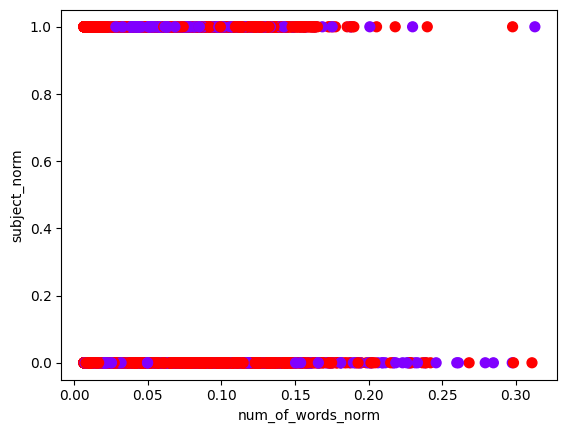

In [265]:
plt.scatter(x_df.iloc[:, 0], x_df.iloc[:, 1], c=y_df, s=50, cmap='rainbow')
plt.xlabel('num_of_words_norm')
plt.ylabel('subject_norm')
plt.show()

In [266]:
print(df['label'].value_counts(normalize=True))
print(f'\nDevido ao desbalanceamento entre as classes, a medição não poderá ser feita por acurácia, como estamos preocupados prioritariamente com o desempenho geral do modelo e sua capacidade de distinguir entre as classes, vamos utilizar a AUC-ROC.')

label
1    0.621658
0    0.378342
Name: proportion, dtype: float64

Devido ao desbalanceamento entre as classes, a medição não poderá ser feita por acurácia, como estamos preocupados prioritariamente com o desempenho geral do modelo e sua capacidade de distinguir entre as classes, vamos utilizar a AUC-ROC.


### Algoritmos

In [267]:
# Define models and hyperparameters
param_grid = {
    "RandomForestClassifier": {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 20]
    },
    "KNeighborsClassifier": {
        'n_neighbors': [3, 5, 7]
    },
    "SVC": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    "LogisticRegression": {
        'C': [0.1, 1, 10],
        'max_iter': [100, 200, 300]
    }
}

models = {
    "RandomForestClassifier": RandomForestClassifier(random_state=1),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "SVC": SVC(probability=True),
    "LogisticRegression": LogisticRegression()
}

In [268]:
def find_best_hyper_parameters(models, xtrain, ytrain):
    best_models = {}
    best_auc_roc = 0
    best_model_name = None
    best_model = None

    for model_name, model in models.items():
        print(f"Treinando {model_name}...")
        grid_search = GridSearchCV(model, param_grid[model_name], scoring='roc_auc', cv=5)
        grid_search.fit(xtrain, ytrain)

        best_models[model_name] = grid_search.best_estimator_
        auc_roc = grid_search.best_score_

        print(f"Melhor parâmetro para {model_name}: {grid_search.best_params_}")
        print(f"Validação AUC-ROC para {model_name}: {auc_roc}")

        # Log the results of each grid search with MLflow
        with mlflow.start_run(run_name=f"{model_name}_GridSearch"):
            mlflow.log_param("model_name", model_name)
            mlflow.log_params(grid_search.best_params_)
            mlflow.log_metric("validation_auc_roc", auc_roc)

        if auc_roc > best_auc_roc:
            best_auc_roc = auc_roc
            best_model_name = model_name
            best_model = grid_search.best_estimator_

    return best_models, best_model


In [269]:
def run_models_using_mlflow(models, xtrain, ytrain, xtest, ytest):
    test_results = {}
    train_results = {} 
    for model_name, model in models.items():
        
        # Predict probabilities for class 1 nos dados de teste
        y_pred_proba_test = model.predict_proba(xtest)[:, 1]
        
        # Calcular AUC-ROC nos dados de teste
        auc_roc_test = roc_auc_score(ytest, y_pred_proba_test)

        # Predict probabilities for class 1 nos dados de treino
        y_pred_proba_train = model.predict_proba(xtrain)[:, 1]
        
        # Calcular AUC-ROC nos dados de treino
        auc_roc_train = roc_auc_score(ytrain, y_pred_proba_train)

        # Log resultados de teste
        test_results[model_name] = auc_roc_test
        print(f"Teste AUC-ROC para {model_name}: {auc_roc_test}")

        # Log resultados de treino
        train_results[model_name] = auc_roc_train
        print(f"Treino AUC-ROC para {model_name}: {auc_roc_train}")

        # Gerar e logar a curva ROC
        fpr, tpr, _ = roc_curve(ytest, y_pred_proba_test)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='b', label=f'ROC Curve (Test AUC = {auc_roc_test:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend()
        plt.show()
        
        # Salvar curva ROC para arquivo
        roc_plot_path = f"roc_curve_{model_name}.png"
        plt.savefig(roc_plot_path)
        plt.close()

        # Gerar e logar a matriz de confusão
        y_pred_test = model.predict(xtest)
        mat = confusion_matrix(ytest, y_pred_test)
        plt.figure(figsize=(8, 6))
        sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues')
        plt.xlabel('True Label')
        plt.ylabel('Predicted Label')
        plt.title(f'Confusion Matrix for {model_name}')
        plt.show()
        
        # Salvar matriz de confusão para arquivo
        confusion_matrix_plot_path = f"confusion_matrix_{model_name}.png"
        plt.savefig(confusion_matrix_plot_path)
        plt.close()

        # Logar resultados com MLflow
        with mlflow.start_run(run_name=model_name):
            mlflow.log_param("model_name", model_name)
            mlflow.log_metric("test_auc_roc", auc_roc_test)
            mlflow.log_metric("train_auc_roc", auc_roc_train)  # Logar AUC-ROC de treino
            mlflow.sklearn.log_model(model, model_name)
            mlflow.log_artifact(roc_plot_path)
            mlflow.log_artifact(confusion_matrix_plot_path)

        # Avaliar overfitting ou underfitting
        if auc_roc_train > auc_roc_test:
            print(f"Warning: {model_name} is overfitting!\n")
        elif auc_roc_train < auc_roc_test:
            print(f"Warning: {model_name} may be underfitting!\n")

    # Determinar o melhor modelo baseado no AUC-ROC de teste
    best_model_name = max(test_results, key=test_results.get)
    print(f"Melhor modelo: {best_model_name} com AUC-ROC: {test_results[best_model_name]}")


In [270]:
mlflow.set_experiment("Multiple Classifier Models")
best_models, best_model = find_best_hyper_parameters(models, xtrain, ytrain)


Treinando RandomForestClassifier...
Melhor parâmetro para RandomForestClassifier: {'max_depth': 10, 'n_estimators': 500}
Validação AUC-ROC para RandomForestClassifier: 0.7987962003925458
Treinando KNeighborsClassifier...
Melhor parâmetro para KNeighborsClassifier: {'n_neighbors': 7}
Validação AUC-ROC para KNeighborsClassifier: 0.7653201377191925
Treinando SVC...
Melhor parâmetro para SVC: {'C': 10, 'kernel': 'rbf'}
Validação AUC-ROC para SVC: 0.7263724690092099
Treinando LogisticRegression...
Melhor parâmetro para LogisticRegression: {'C': 10, 'max_iter': 100}
Validação AUC-ROC para LogisticRegression: 0.6732523052492232


Teste AUC-ROC para RandomForestClassifier: 0.7966316881865511
Treino AUC-ROC para RandomForestClassifier: 0.8222709644798731


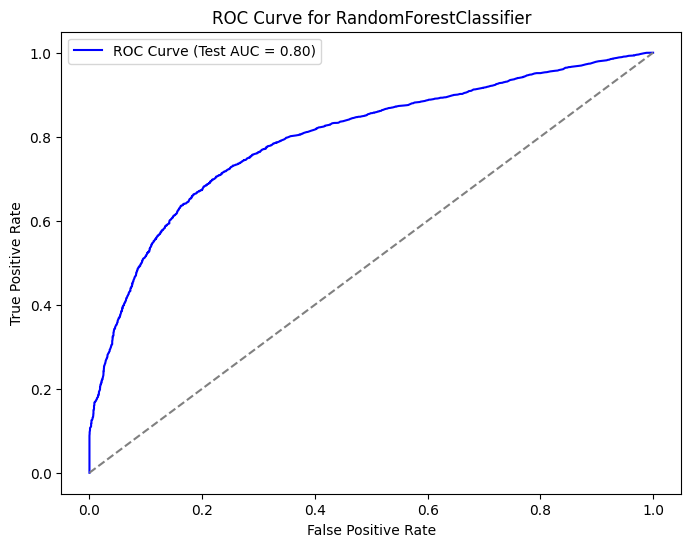

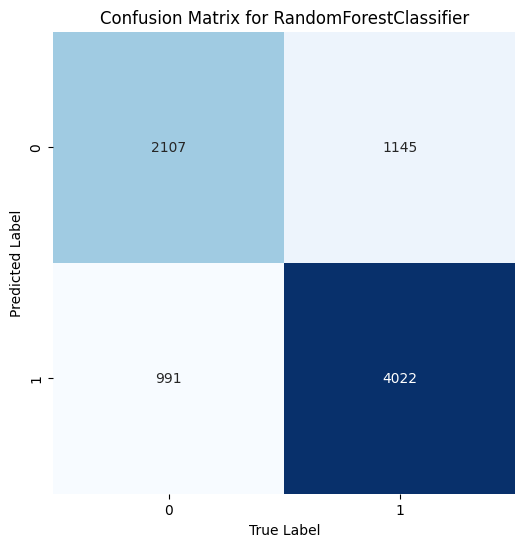


Teste AUC-ROC para KNeighborsClassifier: 0.7637423920962386
Treino AUC-ROC para KNeighborsClassifier: 0.8081574273076755


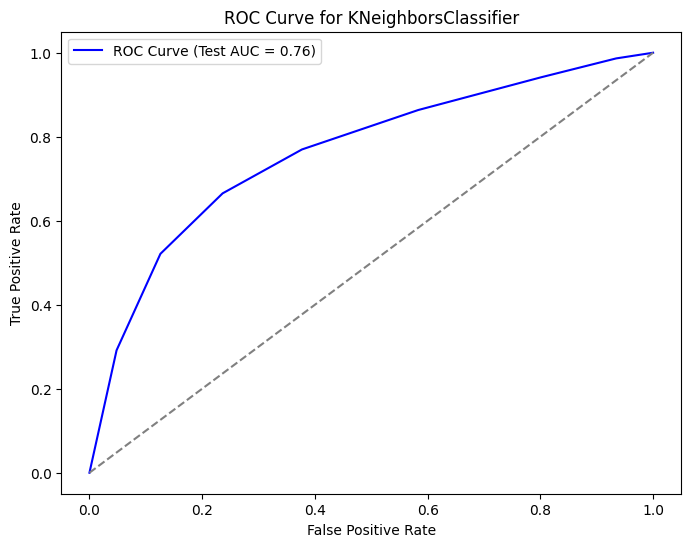

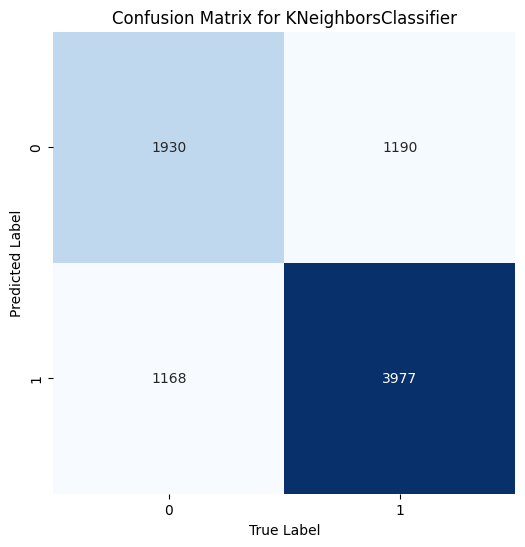


Teste AUC-ROC para SVC: 0.7319323179091425
Treino AUC-ROC para SVC: 0.7331717652861017


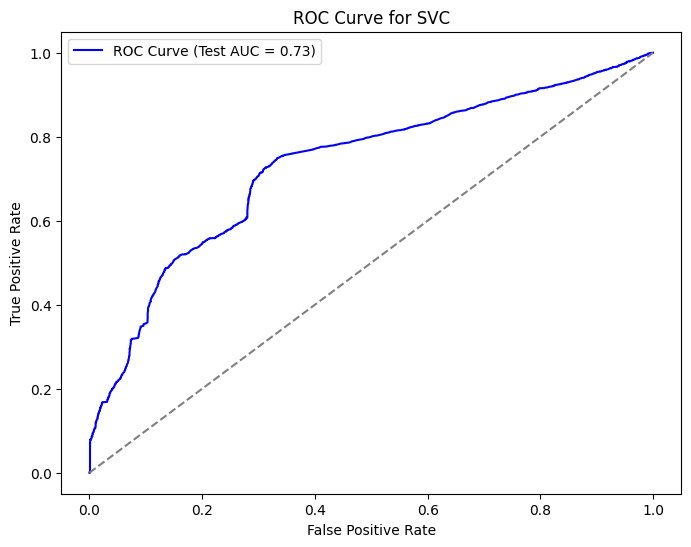

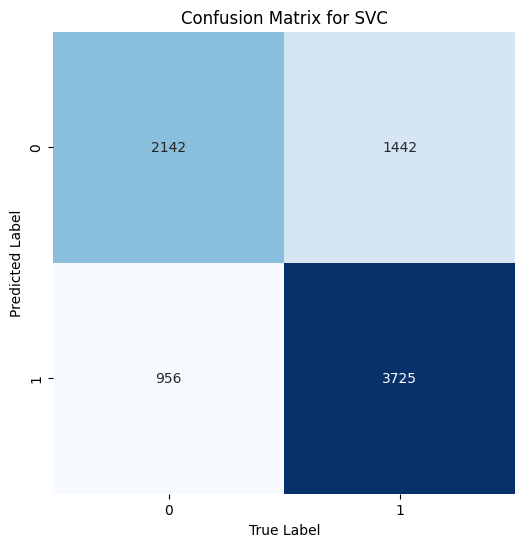


Teste AUC-ROC para LogisticRegression: 0.6670166097282962
Treino AUC-ROC para LogisticRegression: 0.6732305850164585


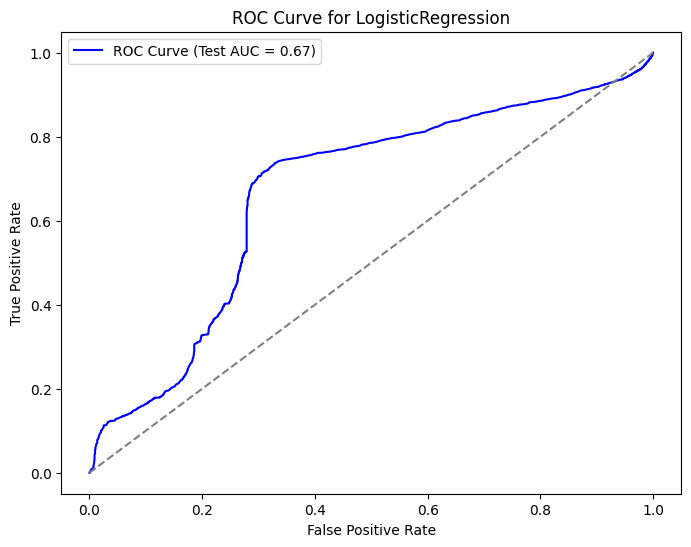

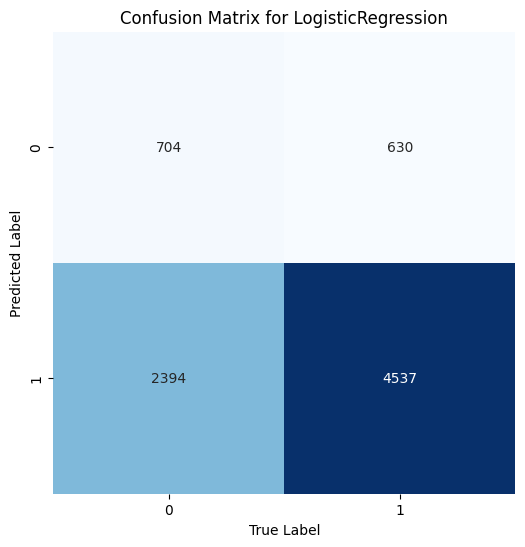


Melhor modelo: RandomForestClassifier com AUC-ROC: 0.7966316881865511


In [271]:
run_models_using_mlflow(best_models, xtrain, ytrain, xtest, ytest)

# Melhora do modelo
Lembrando que o ajuste de hiper parâmetros já foi feito anteriormente, não será necessário o uso dessa técnica.

## Aumento do conjunto de treinamento
O valor default utilizado é tamanho do conjunto de teste em 25%, vamos diminuir para 15%, assim aumentando o tamanho do conjunto de treino

In [301]:
x_df = df[['num_of_words_norm','subject_norm']]
y_df = df['label']
xtrain_modified, xtest_modified, ytrain_modified, ytest_modified = train_test_split(x_df, y_df, random_state=1, test_size=0.15)

In [302]:
best_model.fit(xtrain_modified, ytrain_modified)
# Predict probabilities for class 1 nos dados de teste
y_pred_proba_test = best_model.predict_proba(xtest_modified)[:, 1]

# Calcular AUC-ROC nos dados de teste
auc_roc_test = roc_auc_score(ytest_modified, y_pred_proba_test)

# Predict probabilities for class 1 nos dados de treino
y_pred_proba_train = model.predict_proba(xtrain_modified)[:, 1]

# Calcular AUC-ROC nos dados de treino
auc_roc_train = roc_auc_score(ytrain_modified, y_pred_proba_train)

# Log resultados de teste
print(f"Teste AUC-ROC : {auc_roc_test}")

# Log resultados de treino
print(f"Treino AUC-ROC : {auc_roc_train}")

Teste AUC-ROC : 0.7993193888800294
Treino AUC-ROC : 0.8173356955449905


Resultado: Houve uma diminuição no overfitting do modelo, equilibrando um pouco a validação do conjunto de teste e de treinamento

## Bagging
Ensemble learning que combina múltiplos modelos de machine learning para melhorar a precisão e robustez geral do modelo final. Funciona treinando vários modelos independentes em diferentes subconjuntos aleatórios dos dados de treinamento e depois combinando suas previsões por meio da votação.

In [280]:
from sklearn.ensemble import BaggingClassifier

# Exemplo de Bagging com RandomForestClassifier
bagging_model = BaggingClassifier(estimator=best_model, n_estimators=10, random_state=1)
bagging_model.fit(xtrain, ytrain)
# Predict probabilities for class 1 nos dados de teste
y_pred_proba_test = model.predict_proba(xtest)[:, 1]
xtrain_modified
# Calcular AUC-ROC nos dados de teste
auc_roc_test = roc_auc_score(ytest, y_pred_proba_test)

# Predict probabilities for class 1 nos dados de treino
y_pred_proba_train = model.predict_proba(xtrain)[:, 1]

# Calcular AUC-ROC nos dados de treino
auc_roc_train = roc_auc_score(ytrain, y_pred_proba_train)

# Log resultados de teste
print(f"Teste AUC-ROC : {auc_roc_test}")

# Log resultados de treino
print(f"Treino AUC-ROC : {auc_roc_train}")
Resultado: Houve uma diminuição no overfitting do modelo, equilibrando a validação do conjunto de teste e de treinamento

Teste AUC-ROC : 0.7940609654330388
Treino AUC-ROC : 0.7959237142875891


Resultado: Houve uma diminuição no overfitting do modelo, equilibrando a validação do conjunto de teste e de treinamento

## Balanceamento de Dados
Técnica de oversampling da classe minoritária ou undersampling da classe majoritária para melhorar o desempenho do modelo

In [283]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(x_df, y_df)

model = best_model.fit(X_resampled, y_resampled)
# Predict probabilities for class 1 nos dados de teste
y_pred_proba_test = model.predict_proba(xtest)[:, 1]

# Calcular AUC-ROC nos dados de teste
auc_roc_test = roc_auc_score(ytest, y_pred_proba_test)

# Predict probabilities for class 1 nos dados de treino
y_pred_proba_train = model.predict_proba(xtrain)[:, 1]

# Calcular AUC-ROC nos dados de treino
auc_roc_train = roc_auc_score(ytrain, y_pred_proba_train)

# Log resultados de teste
print(f"Teste AUC-ROC : {auc_roc_test}")

# Log resultados de treino
print(f"Treino AUC-ROC : {auc_roc_train}")


Teste AUC-ROC : 0.8148981537624616
Treino AUC-ROC : 0.7959237142875891


Resultado: Houve uma melhora do modelo, com a métrica de validação no conjunto de teste maior, significando que  o modelo está generalizando bem para dados não vistos.

## Diminuição da complexidade do modelo
Aumentar min_samples_split e min_samples_leaf em modelos de árvores de decisão limita sua capacidade de se ajustar excessivamente aos dados de treinamento e melhorando sua capacidade de generalização para novos dados.

In [289]:
new_params = {
    'min_samples_split': 10,
    'min_samples_leaf': 10
}

# Adicionando os novos parâmetros ao modelo existente
model = best_model.set_params(**new_params)
model.fit(xtrain, ytrain)
# Predict probabilities for class 1 nos dados de teste
y_pred_proba_test = model.predict_proba(xtest)[:, 1]

# Calcular AUC-ROC nos dados de teste
auc_roc_test = roc_auc_score(ytest, y_pred_proba_test)

# Predict probabilities for class 1 nos dados de treino
y_pred_proba_train = model.predict_proba(xtrain)[:, 1]

# Calcular AUC-ROC nos dados de treino
auc_roc_train = roc_auc_score(ytrain, y_pred_proba_train)

# Log resultados de teste
print(f"Teste AUC-ROC : {auc_roc_test}")

# Log resultados de treino
print(f"Treino AUC-ROC : {auc_roc_train}")

Teste AUC-ROC : 0.7968178837167837
Treino AUC-ROC : 0.8193587298999778


Resultado: Não houve uma melhora do modelo

# Modelo final Junção da técnicas (bagging + balanceamento dos dados + Aumento do conjunto de treinamento)

In [315]:
# Balanceamento dos dados
ros = RandomOverSampler(random_state=1)
x_df_resampled, y_df_resampled = ros.fit_resample(x_df, y_df)

# Aumento do conjunto de treinamento
xtrain_modified, xtest_modified, ytrain_modified, ytest_modified = train_test_split(x_df_resampled, y_df_resampled, random_state=1, test_size=0.15)

# Bagging de RandomForest
bagging_model = BaggingClassifier(estimator=best_model, n_estimators=10, random_state=1)
bagging_model.fit(xtrain_modified, ytrain_modified)

# Predict probabilities for class 1 nos dados de teste
y_pred_proba_test = bagging_model.predict_proba(xtest_modified)[:, 1]

# Calcular AUC-ROC nos dados de teste
auc_roc_test = roc_auc_score(ytest_modified, y_pred_proba_test)

# Predict probabilities for class 1 nos dados de treino
y_pred_proba_train = model.predict_proba(xtrain_modified)[:, 1]

# Calcular AUC-ROC nos dados de treino
auc_roc_train = roc_auc_score(ytrain_modified, y_pred_proba_train)

# Log resultados de teste
print(f"Teste AUC-ROC : {auc_roc_test}")

# Log resultados de treino
print(f"Treino AUC-ROC : {auc_roc_train}")

Teste AUC-ROC : 0.8129466177513452
Treino AUC-ROC : 0.813840723853344
